In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
from functorch import jacfwd  # Import from functorch

from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import Double_Pendulum.Lumped_Mass.robot_parameters as robot_parameters
import Double_Pendulum.Lumped_Mass.transforms as transforms
import Double_Pendulum.Lumped_Mass.dynamics as dynamics

In [2]:
rp = robot_parameters.LUMPED_PARAMETERS
print(rp)

{'l1': 2, 'l2': 2, 'm': 3, 'g': 9.81, 'xa': 5, 'ya': 1}


In [3]:
import numpy as np

# Number of samples
q1_low  = -torch.pi/2
q1_high =  torch.pi/2
q2_low  = -torch.pi/2
q2_high =  torch.pi/2
q1_d_low  = -torch.pi/2
q1_d_high =  torch.pi/2
q2_d_low  = -torch.pi/2
q2_d_high =  torch.pi/2


n_samples = 100000

# Generate uniformly distributed points for q1 and q2
q1 = torch.linspace(q1_low, q1_high, n_samples)
q2 = torch.linspace(q2_low, q2_high, n_samples)
q1_d = torch.linspace(q1_d_low, q1_d_high, n_samples)
q2_d = torch.linspace(q2_d_low, q2_d_high, n_samples)

idx = torch.randperm(q2.shape[0])
idx2 = torch.randperm(q1_d.shape[0])
idx3 = torch.randperm(q2_d.shape[0])

q2 = q2[idx]
q1_d = q1_d[idx2]
q2_d = q2_d[idx3]

# Stack q1 and q2 to get the 2D coordinates
points = torch.stack([q1, q2, q1_d, q2_d], axis=1)  # Shape will be (1000, 2)

In [4]:
# Use TensorDataset to create the dataset
dataset = TensorDataset(points)

# Create the DataLoader with batch size and shuffling
batch_size = 64
dataloader = DataLoader(dataset, 
                        batch_size=batch_size, 
                        shuffle=True,
                        num_workers=0,
                        pin_memory=True)


# Example usage: iterate through the DataLoader
for batch in dataloader:
    #print(batch[0])
    break  # Just to show one batch

/home/kian/anaconda3/envs/thesis/lib/python3.12/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
class SinCosLayer(nn.Module):
    def __init__(self):
        super(SinCosLayer, self).__init__()

    def forward(self, x):
        # Apply sin() and cos() to both coordinates
        x_sin = torch.sin(x)
        x_cos = torch.cos(x)
        x_sin_cos_shape = (x.shape[0], x.shape[1]*2)
        x_sin_cos = torch.empty(x_sin_cos_shape, dtype=x_sin.dtype, device=x.device)
        x_sin_cos[:,0::2] = x_sin
        x_sin_cos[:,1::2] = x_cos
        return x_sin_cos
    
# Custom layer to reverse the interleaved sin() and cos() back to original coordinates
class InverseSinCosLayer(nn.Module):
    def __init__(self):
        super(InverseSinCosLayer, self).__init__()

    def forward(self, x):
        # x contains interleaved sin() and cos() values
        # Assuming input is of shape (batch_size, 4) for 2D coordinates
        sin_vals = x[:, 0::2]  # Extract sin values
        cos_vals = x[:, 1::2]  # Extract cos values

        # Use atan2 to recover the original angles from sin and cos
        original_coords = torch.atan2(sin_vals, cos_vals)
        return original_coords
    



class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            #SinCosLayer(),
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1)#,
            #InverseSinCosLayer()
        )
        
        self.decoder = nn.Sequential(
            #SinCosLayer(),
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 2)#,
            #InverseSinCosLayer()
        )
    
    def forward(self, q):
        analytic_theta_1_vmap = torch.vmap(transforms.analytic_theta_1, in_dims = (None, 0))
        theta_1 = analytic_theta_1_vmap(rp, q).unsqueeze(1)
        #theta_1 = transforms.analytic_theta_1(rp, q).unsqueeze(1)
        theta_2 = self.encoder(q)
        theta = torch.stack((theta_1, theta_2), dim=1).squeeze(2)
        q_hat = self.decoder(theta)
        return(theta, q_hat)

In [22]:
%%time

rp = robot_parameters.LUMPED_PARAMETERS

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder().to(device)  # Move model to GPU

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
#scheduler.get_last_lr()


num_epochs = 30
lambda_reg = 1e-4
outputs = []

# Define a function that takes `q` as input and returns `theta`
def compute_theta(q):
    return model(q)[0]  # This will return `theta`


for epoch in range(num_epochs):
    for index, batch in enumerate(dataloader):
        q = batch[0][:, 0:2].to(device)
        q_d = batch[0][:, 2:4].to(device)
        theta, q_hat = model(q)
        
        #Jh_func = torch.vmap(jacrev(compute_theta)) #Doesn't work due to batch handling in transforms.py
        
        Jh_func = jacfwd(compute_theta)
        
        Jh_messy = Jh_func(q)
        
        Jh_blocks = Jh_messy.view(batch[0].shape[0], 2, batch[0].shape[0], 2)  # [64, 2, 64, 2]
        Jh = torch.stack([Jh_blocks[i, :, i, :] for i in range(batch[0].shape[0])])
        
        
        Jh_inv = torch.linalg.pinv(Jh)
        Jh_invtrans = Jh_inv.transpose(1, 2)
        
        matrices_vmap = torch.vmap(dynamics.dynamical_matrices, in_dims=(None, 0, 0))
        
        Mq, Cq, Gq = matrices_vmap(rp, q, q_d)        
        loss_reconstruction = criterion(q_hat, q)
        loss_theta = criterion(theta, q)
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss = loss_reconstruction + loss_theta #+ lambda_reg * l1_norm
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()
        
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.9f}')
    print("l1 norm loss:", (l1_norm*lambda_reg).item())
    outputs.append((epoch, q, q_hat, theta))

epoch: 0


<timed exec>:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacfwd` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacfwd` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html


Epoch:1, Loss:6.424521923
l1 norm loss: 0.008783768862485886
epoch: 1
Epoch:2, Loss:6.437801838
l1 norm loss: 0.009638282470405102
epoch: 2
Epoch:3, Loss:8.037160873
l1 norm loss: 0.009837151505053043
epoch: 3
Epoch:4, Loss:5.793663025
l1 norm loss: 0.009941942989826202
epoch: 4
Epoch:5, Loss:6.791546345
l1 norm loss: 0.010056315921247005
epoch: 5
Epoch:6, Loss:5.657609463
l1 norm loss: 0.01024395227432251
epoch: 6
Epoch:7, Loss:6.593131065
l1 norm loss: 0.010532229207456112
epoch: 7
Epoch:8, Loss:7.830127716
l1 norm loss: 0.010750729590654373
epoch: 8
Epoch:9, Loss:7.887618542
l1 norm loss: 0.01088370569050312
epoch: 9
Epoch:10, Loss:7.119999409
l1 norm loss: 0.010988770984113216
epoch: 10
Epoch:11, Loss:7.203209400
l1 norm loss: 0.011073085479438305
epoch: 11
Epoch:12, Loss:5.956668854
l1 norm loss: 0.011147653684020042
epoch: 12
Epoch:13, Loss:7.163070202
l1 norm loss: 0.011209745891392231
epoch: 13
Epoch:14, Loss:6.824512959
l1 norm loss: 0.011265626177191734
epoch: 14
Epoch:15, Lo

KeyboardInterrupt: 

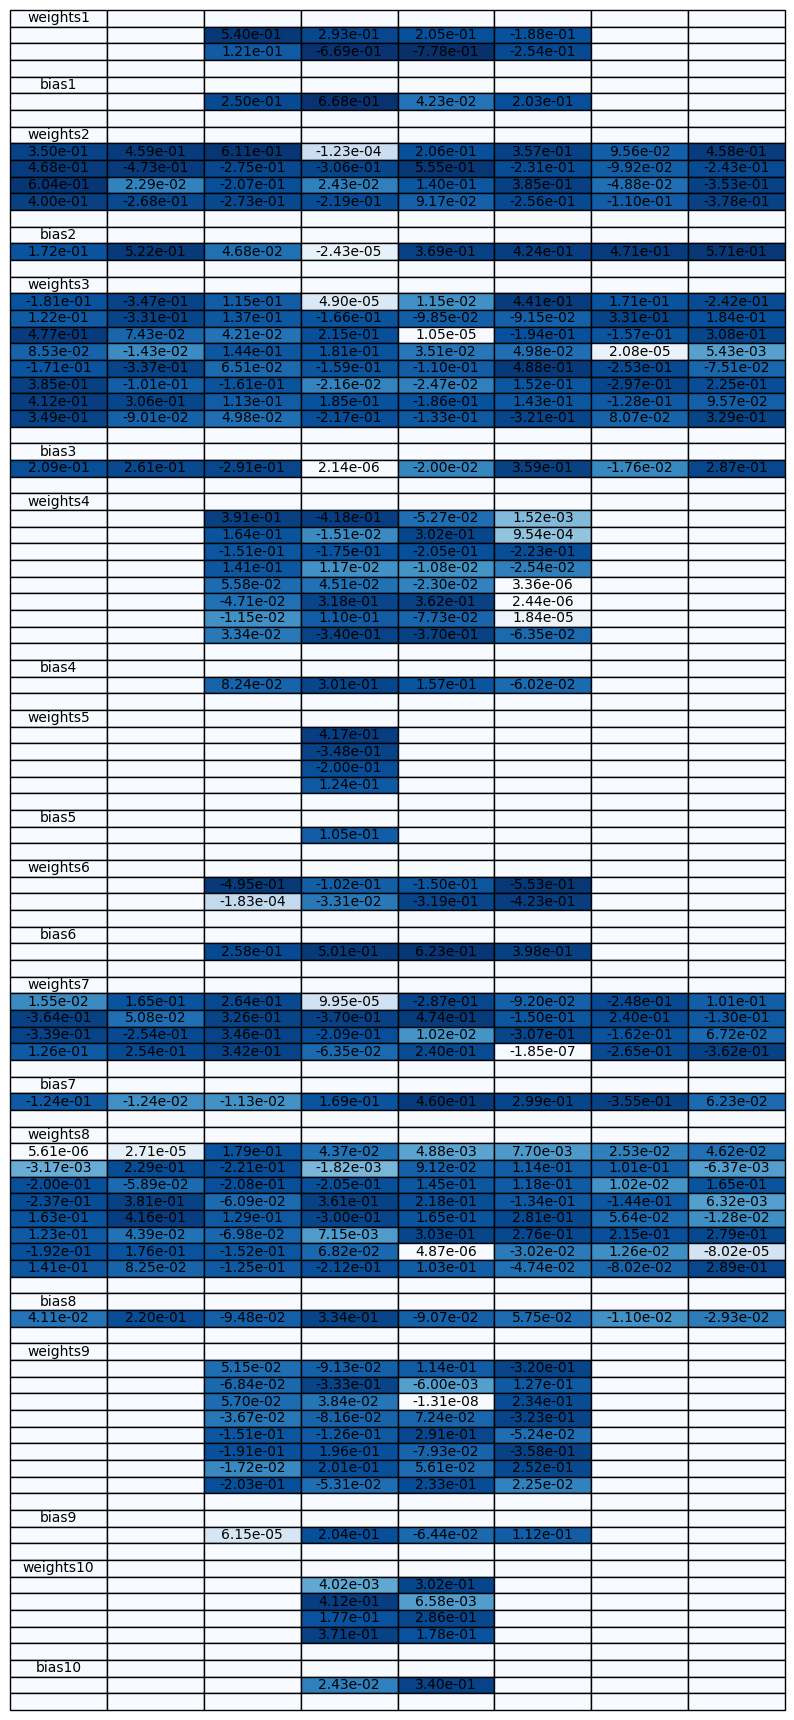

In [7]:
import random
import string

max_neurons = 8
blank_layer = [None for _ in range(max_neurons)]

table_layers = []
for idx, param in enumerate(model.parameters()):
    layer = param.data
    num_parallel = layer.shape[0]
    side_padding = int((max_neurons - num_parallel)/2)
    
    if idx % 2 == 0:
        
        table_layer = blank_layer.copy()
        table_layer[0] = "weights" + str(idx//2+1)
        table_layers.append(table_layer)
        for i in range(layer.shape[1]):
            table_layer = blank_layer.copy()
            for j in range(num_parallel):
                table_layer[j+side_padding] = '{:.2e}'.format(layer[j][i].item())
            table_layers.append(table_layer)
        table_layers.append(blank_layer)
            
    else:  
        
        table_layer = blank_layer.copy()
        table_layer[0] = "bias" + str(idx//2+1)
        table_layers.append(table_layer)
        table_layer = blank_layer.copy()
        for j in range(num_parallel):
            table_layer[j+side_padding] = '{:.2e}'.format(layer[j].item())
        table_layers.append(table_layer)
        table_layers.append(blank_layer)

numeric_values = np.zeros((len(table_layers), max_neurons))
for i, row in enumerate(table_layers):
    for j, item in enumerate(row):
        if item not in (None, "weights1", "weights2", "bias1", "bias2"):  # Replace with relevant layer names
            try:
                numeric_values[i, j] = (float(item))
            except ValueError:
                pass
        
min_val, max_val = numeric_values.min(), numeric_values.max()


# Step 2: Apply a logarithmic transformation, setting a small threshold to avoid log(0)
threshold = 1e-5
log_values = np.log10(np.clip(np.abs(numeric_values), threshold, None))

# Normalize the log-scaled values to range between 0 and 1
normalized_values = (log_values - log_values.min()) / (log_values.max() - log_values.min())
colors = plt.cm.Blues(normalized_values)

        
# Plot the table
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')

# Create table
table = plt.table(cellText=table_layers, cellColours=colors, loc='center', cellLoc='center')

plt.show()

In [8]:
test_q = torch.Tensor([1, 1])
test_q_d = torch.Tensor([1, 1])

M, C, G = dynamics.dynamical_matrices(rp, test_q, test_q_d)
print(M)
print(C)
print(G)

M2, C2, G2 = dynamics.dynamical_matrices_set(test_q, test_q_d)
print(M2)
print(C2)
print(G2)


tensor([[12., 12.],
        [12., 12.]])
tensor([[  0.,  12.],
        [-12.,   0.]])
tensor([[31.8022],
        [31.8022]])
tensor([[12.0000,  6.4836],
        [ 6.4836, 12.0000]])
tensor([[12., 12.],
        [12., 12.]])
tensor([[  0.,  12.],
        [-12.,   0.]])
tensor([[31.8022],
        [31.8022]])
